# 04-001 : Features - Random Forest Baseline - [0.664] :: 001

Attempt to replicate the results from `001_random-forest-baseline-0-664.ipynb`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import logging
from typing import Any, Dict, List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from tqdm.auto import tqdm

import tensorflow_addons as tfa
import keras as k
from keras import optimizers
import keras_tuner
import keras_tuner as kt

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from competition import data_preparation as dp
from competition import feature_engineering as fe
from competition import model_data as md
from competition import source_data as sd
import competition.models.simple_dense as sd_model
from competition.models.heatmap_covnet import HeatmapCovnetModel

from competition.model_training import mprint, mflush, mclear
from competition.predict import PredictionBase, Baseline, HeatmapPredictor

2023-04-21 12:57:14.667434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Configure Logging

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-04-21 12:57:15 INFO     Started


## Data Collection

In [4]:
# load the source training set
df_source = sd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=sd.source_dtype)

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [5]:
# load the source training labels
df_source_labels = sd.read_csv('../data/train_labels.csv')

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [6]:
# prepare the main dataset
df_source = dp.prepare_main_dataset(df_source)

# remove sessions with problems
problem_sessions = dp.find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

In [7]:
# prepare the label dataset
df_source_labels = dp.prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

## Feature Engineering

In [8]:
# create the initial features
df_features = fe.create_initial_features(df_source, df_source_labels)

In [9]:
# add the elapsed time feature to the features dataset
df_features = fe.add_elapsed_time_features(
    features=df_features,
    X=df_source)

In [10]:
# add the total count features to the features dataset
df_features = fe.add_count_total_features(
    features=df_features,
    X=df_source)

In [11]:
# add the unique count features to the features dataset
df_features = fe.add_count_unique_features(
    features=df_features,
    X=df_source)

In [12]:
# add the numeric features to the features dataset
df_features = fe.add_numeric_features(
    features=df_features,
    X=df_source)

In [21]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(df_features.dtypes))

,0
session_id,int64
level_group,object
elapsed_time_sum,float64
elapsed_time_max,float64
elapsed_time_min,float64
elapsed_time_mean,float64
elapsed_time_mode,float64
elapsed_time_std,float64
count_total_event_name,float64
count_total_name,float64


In [14]:
[
    'level_group',
    'count_unique_event_name',
    'count_unique_name',
    'count_unique_fqid',
    'count_unique_room_fqid',
    'count_unique_text_fqid',
    'elapsed_time_mean',
    
]

['level_group',
 'count_unique_event_name',
 'count_unique_name',
 'count_unique_fqid',
 'count_unique_room_fqid',
 'count_unique_text_fqid',
 'elapsed_time_mean']

count    1.301979e+07
mean     1.218992e+01
std      6.498517e+00
min      0.000000e+00
25%      6.000000e+00
50%      1.300000e+01
75%      1.800000e+01
max      2.200000e+01
Name: level, dtype: float64


<AxesSubplot: >

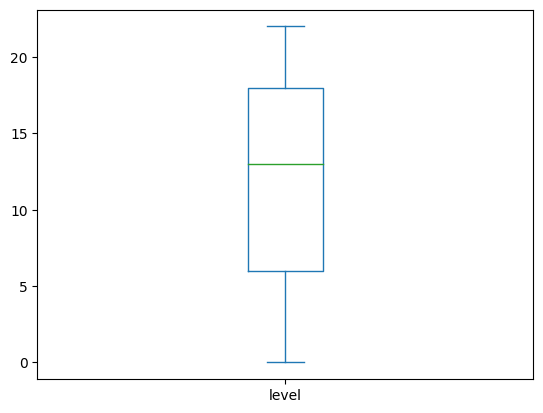

In [15]:
print(df_source.level.describe())
df_source.level.plot(kind='box')